In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import shutil

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
BACKBONE = 'resnet50'

In [4]:
heigh = 256

In [5]:
#model = sm.Unet(BACKBONE, encoder_weights='imagenet')
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [6]:
#dataset = DatasetCreator(sm.get_preprocessing(BACKBONE))
dataset = DatasetCreator(modelcreator.getpreprocess())

In [7]:
valdata = dataset('crosval/val/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))
len(valdata)

6

In [8]:
testaugmentation = albu.Compose([
    albu.Resize(heigh,heigh,always_apply=True),
    albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    albu.HorizontalFlip(p=0.5),
    albu.RandomRotate90(),
    albu.GaussianBlur(),
    albu.GaussNoise()
    ])

In [9]:
traindata = dataset('crosval/train/*png','castom-masks/masks_machine/',testaugmentation)
len(traindata)

13

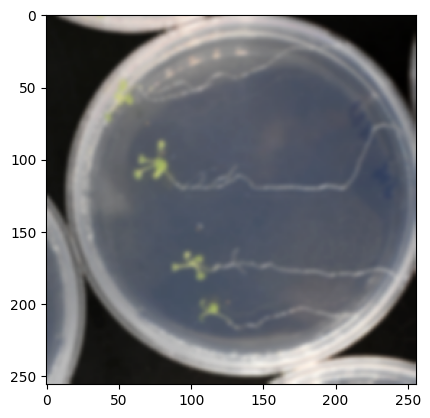

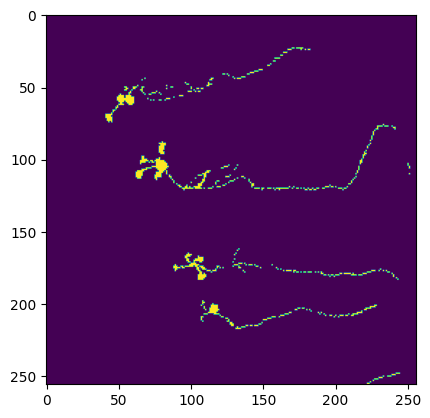

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [11]:
#tf.keras.utils.plot_model(model)

In [12]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 10 and epoch % 5 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=20,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='libbestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [13]:
# fit model
model_history = model.fit(
    traindata,
    epochs=60,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60


13/13 [==============================] - ETA: 0s - loss: 2.8966 - iou_score: 0.0095
Epoch 1: val_loss improved from inf to 8.75643, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 12s 673ms/step - loss: 2.8966 - iou_score: 0.0095 - val_loss: 8.7564 - val_iou_score: 0.0097 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
13/13 [==============================] - ETA: 0s - loss: 1.7535 - iou_score: 0.0106
Epoch 2: val_loss improved from 8.75643 to 4.33168, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 642ms/step - loss: 1.7535 - iou_score: 0.0106 - val_loss: 4.3317 - val_iou_score: 0.0091 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/60
13/13 [==============================] - ETA: 0s - loss: 1.4478 - iou_score: 0.0110
Epoch 3: val_loss improved from 4.33168 to 2.98125, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 636ms/step - loss: 1.4478 - iou_score: 0.0110 - val_loss: 2.9812 - val_iou_score: 0.0086 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/60
13/13 [==============================] - ETA: 0s - loss: 1.2870 - iou_score: 0.0121
Epoch 4: val_loss improved from 2.98125 to 2.57168, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 637ms/step - loss: 1.2870 - iou_score: 0.0121 - val_loss: 2.5717 - val_iou_score: 0.0088 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/60
13/13 [==============================] - ETA: 0s - loss: 1.1897 - iou_score: 0.0134
Epoch 5: val_loss did not improve from 2.57168
13/13 [==============================] - 9s 496ms/step - loss: 1.1897 - iou_score: 0.0134 - val_loss: 2.7179 - val_iou_score: 0.0090 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/60
13/13 [==============================] - ETA: 0s - loss: 1.1225 - iou_score: 0.0189
Epoch 6: val_loss improved from 2.57168 to 2.19287, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 639ms/step - loss: 1.1225 - iou_score: 0.0189 - val_loss: 2.1929 - val_iou_score: 0.0090 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/60
13/13 [==============================] - ETA: 0s - loss: 1.0787 - iou_score: 0.0270
Epoch 7: val_loss improved from 2.19287 to 1.50440, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 634ms/step - loss: 1.0787 - iou_score: 0.0270 - val_loss: 1.5044 - val_iou_score: 0.0105 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/60
13/13 [==============================] - ETA: 0s - loss: 1.0563 - iou_score: 0.0374
Epoch 8: val_loss did not improve from 1.50440
13/13 [==============================] - 9s 494ms/step - loss: 1.0563 - iou_score: 0.0374 - val_loss: 1.8447 - val_iou_score: 0.0102 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/60
13/13 [==============================] - ETA: 0s - loss: 1.0369 - iou_score: 0.0475
Epoch 9: val_loss improved from 1.50440 to 1.45846, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 638ms/step - loss: 1.0369 - iou_score: 0.0475 - val_loss: 1.4585 - val_iou_score: 0.0137 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/60
13/13 [==============================] - ETA: 0s - loss: 1.0157 - iou_score: 0.0598
Epoch 10: val_loss improved from 1.45846 to 1.19929, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 636ms/step - loss: 1.0157 - iou_score: 0.0598 - val_loss: 1.1993 - val_iou_score: 0.0148 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/60
13/13 [==============================] - ETA: 0s - loss: 1.0041 - iou_score: 0.0650
Epoch 11: val_loss improved from 1.19929 to 1.19794, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 643ms/step - loss: 1.0041 - iou_score: 0.0650 - val_loss: 1.1979 - val_iou_score: 0.0162 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/60
13/13 [==============================] - ETA: 0s - loss: 0.9894 - iou_score: 0.0769
Epoch 12: val_loss improved from 1.19794 to 1.07512, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 642ms/step - loss: 0.9894 - iou_score: 0.0769 - val_loss: 1.0751 - val_iou_score: 0.0223 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/60
13/13 [==============================] - ETA: 0s - loss: 0.9633 - iou_score: 0.1011
Epoch 13: val_loss improved from 1.07512 to 1.04407, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 642ms/step - loss: 0.9633 - iou_score: 0.1011 - val_loss: 1.0441 - val_iou_score: 0.0266 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/60
13/13 [==============================] - ETA: 0s - loss: 0.9470 - iou_score: 0.1128
Epoch 14: val_loss did not improve from 1.04407
13/13 [==============================] - 9s 499ms/step - loss: 0.9470 - iou_score: 0.1128 - val_loss: 1.0474 - val_iou_score: 0.0310 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/60
13/13 [==============================] - ETA: 0s - loss: 0.9448 - iou_score: 0.1169
Epoch 15: val_loss improved from 1.04407 to 1.01598, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 639ms/step - loss: 0.9448 - iou_score: 0.1169 - val_loss: 1.0160 - val_iou_score: 0.0384 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 16/60
13/13 [==============================] - ETA: 0s - loss: 0.9087 - iou_score: 0.1436
Epoch 16: val_loss did not improve from 1.01598
13/13 [==============================] - 9s 498ms/step - loss: 0.9087 - iou_score: 0.1436 - val_loss: 1.0166 - val_iou_score: 0.0334 - lr: 9.0484e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 17/60
13/13 [==============================] - ETA: 0s - loss: 0.8771 - iou_score: 0.1779
Epoch 17: val_loss improved from 1.01598 to 0.99490, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 633ms/step - loss: 0.8771 - iou_score: 0.1779 - val_loss: 0.9949 - val_iou_score: 0.0539 - lr: 9.0484e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 18/60
13/13 [==============================] - ETA: 0s - loss: 0.8756 - iou_score: 0.1792
Epoch 18: val_loss did not improve from 0.99490
13/13 [==============================] - 9s 500ms/step - loss: 0.8756 - iou_score: 0.1792 - val_loss: 1.0153 - val_iou_score: 0.0555 - lr: 9.0484e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 19/60
13/13 [==============================] - ETA: 0s - loss: 0.8473 - iou_score: 0.2065
Epoch 19: val_loss did not improve from 0.99490
13/13 [==============================] - 9s 497ms/step - loss: 0.8473 - iou_score: 0.2065 - val_loss: 1.0095 - val_iou_score: 0.0598 - lr: 9.0484e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 20/60
13/13 

INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 635ms/step - loss: 0.8496 - iou_score: 0.2013 - val_loss: 0.9656 - val_iou_score: 0.0838 - lr: 9.0484e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 21/60
13/13 [==============================] - ETA: 0s - loss: 0.8267 - iou_score: 0.2259
Epoch 21: val_loss improved from 0.96557 to 0.94747, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 649ms/step - loss: 0.8267 - iou_score: 0.2259 - val_loss: 0.9475 - val_iou_score: 0.0968 - lr: 8.1873e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 22/60
13/13 [==============================] - ETA: 0s - loss: 0.8274 - iou_score: 0.2261
Epoch 22: val_loss improved from 0.94747 to 0.94446, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 636ms/step - loss: 0.8274 - iou_score: 0.2261 - val_loss: 0.9445 - val_iou_score: 0.1018 - lr: 8.1873e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 23/60
13/13 [==============================] - ETA: 0s - loss: 0.8042 - iou_score: 0.2491
Epoch 23: val_loss improved from 0.94446 to 0.94435, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 637ms/step - loss: 0.8042 - iou_score: 0.2491 - val_loss: 0.9444 - val_iou_score: 0.1026 - lr: 8.1873e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 24/60
13/13 [==============================] - ETA: 0s - loss: 0.7949 - iou_score: 0.2592
Epoch 24: val_loss improved from 0.94435 to 0.93714, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 637ms/step - loss: 0.7949 - iou_score: 0.2592 - val_loss: 0.9371 - val_iou_score: 0.1092 - lr: 8.1873e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 25/60
13/13 [==============================] - ETA: 0s - loss: 0.7864 - iou_score: 0.2641
Epoch 25: val_loss improved from 0.93714 to 0.89054, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 645ms/step - loss: 0.7864 - iou_score: 0.2641 - val_loss: 0.8905 - val_iou_score: 0.1514 - lr: 8.1873e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 26/60
13/13 [==============================] - ETA: 0s - loss: 0.7821 - iou_score: 0.2731
Epoch 26: val_loss improved from 0.89054 to 0.88808, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 639ms/step - loss: 0.7821 - iou_score: 0.2731 - val_loss: 0.8881 - val_iou_score: 0.1599 - lr: 7.4082e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 27/60
13/13 [==============================] - ETA: 0s - loss: 0.7689 - iou_score: 0.2824
Epoch 27: val_loss improved from 0.88808 to 0.86327, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 641ms/step - loss: 0.7689 - iou_score: 0.2824 - val_loss: 0.8633 - val_iou_score: 0.1779 - lr: 7.4082e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 28/60
13/13 [==============================] - ETA: 0s - loss: 0.7880 - iou_score: 0.2643
Epoch 28: val_loss improved from 0.86327 to 0.85272, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 641ms/step - loss: 0.7880 - iou_score: 0.2643 - val_loss: 0.8527 - val_iou_score: 0.1884 - lr: 7.4082e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 29/60
13/13 [==============================] - ETA: 0s - loss: 0.7717 - iou_score: 0.2807
Epoch 29: val_loss did not improve from 0.85272
13/13 [==============================] - 9s 504ms/step - loss: 0.7717 - iou_score: 0.2807 - val_loss: 0.9133 - val_iou_score: 0.1455 - lr: 7.4082e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 30/60
13/13 [==============================] - ETA: 0s - loss: 0.7657 - iou_score: 0.2834
Epoch 30: val_loss did not improve from 0.85272
13/13 [==============================] - 9s 498ms/step - loss: 0.7657 - iou_score: 0.2834 - val_loss: 0.9135 - val_iou_score: 0.1349 - lr: 7.4082e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 31/60
13/13 

INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 645ms/step - loss: 0.7664 - iou_score: 0.2871 - val_loss: 0.8218 - val_iou_score: 0.2290 - lr: 6.7032e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 32/60
13/13 [==============================] - ETA: 0s - loss: 0.7722 - iou_score: 0.2799
Epoch 32: val_loss improved from 0.82185 to 0.81258, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 638ms/step - loss: 0.7722 - iou_score: 0.2799 - val_loss: 0.8126 - val_iou_score: 0.2325 - lr: 6.7032e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 33/60
13/13 [==============================] - ETA: 0s - loss: 0.7487 - iou_score: 0.3030
Epoch 33: val_loss improved from 0.81258 to 0.79958, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 640ms/step - loss: 0.7487 - iou_score: 0.3030 - val_loss: 0.7996 - val_iou_score: 0.2432 - lr: 6.7032e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 34/60
13/13 [==============================] - ETA: 0s - loss: 0.7574 - iou_score: 0.2951
Epoch 34: val_loss did not improve from 0.79958
13/13 [==============================] - 9s 504ms/step - loss: 0.7574 - iou_score: 0.2951 - val_loss: 0.8335 - val_iou_score: 0.2037 - lr: 6.7032e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 35/60
13/13 [==============================] - ETA: 0s - loss: 0.7536 - iou_score: 0.2965
Epoch 35: val_loss improved from 0.79958 to 0.79909, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 641ms/step - loss: 0.7536 - iou_score: 0.2965 - val_loss: 0.7991 - val_iou_score: 0.2476 - lr: 6.7032e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 36/60
13/13 [==============================] - ETA: 0s - loss: 0.7508 - iou_score: 0.2999
Epoch 36: val_loss did not improve from 0.79909
13/13 [==============================] - 9s 496ms/step - loss: 0.7508 - iou_score: 0.2999 - val_loss: 0.8167 - val_iou_score: 0.2288 - lr: 6.0653e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 37/60
13/13 [==============================] - ETA: 0s - loss: 0.7356 - iou_score: 0.3128
Epoch 37: val_loss improved from 0.79909 to 0.78891, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 642ms/step - loss: 0.7356 - iou_score: 0.3128 - val_loss: 0.7889 - val_iou_score: 0.2518 - lr: 6.0653e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 38/60
13/13 [==============================] - ETA: 0s - loss: 0.7333 - iou_score: 0.3148
Epoch 38: val_loss improved from 0.78891 to 0.77531, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 658ms/step - loss: 0.7333 - iou_score: 0.3148 - val_loss: 0.7753 - val_iou_score: 0.2706 - lr: 6.0653e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 39/60
13/13 [==============================] - ETA: 0s - loss: 0.7330 - iou_score: 0.3156
Epoch 39: val_loss did not improve from 0.77531
13/13 [==============================] - 9s 509ms/step - loss: 0.7330 - iou_score: 0.3156 - val_loss: 0.7784 - val_iou_score: 0.2660 - lr: 6.0653e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 40/60
13/13 [==============================] - ETA: 0s - loss: 0.7406 - iou_score: 0.3095
Epoch 40: val_loss improved from 0.77531 to 0.74103, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 653ms/step - loss: 0.7406 - iou_score: 0.3095 - val_loss: 0.7410 - val_iou_score: 0.3003 - lr: 6.0653e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 41/60
13/13 [==============================] - ETA: 0s - loss: 0.7268 - iou_score: 0.3210
Epoch 41: val_loss did not improve from 0.74103
13/13 [==============================] - 9s 521ms/step - loss: 0.7268 - iou_score: 0.3210 - val_loss: 0.7709 - val_iou_score: 0.2730 - lr: 5.4881e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 42/60
13/13 [==============================] - ETA: 0s - loss: 0.7395 - iou_score: 0.3116
Epoch 42: val_loss did not improve from 0.74103
13/13 [==============================] - 9s 500ms/step - loss: 0.7395 - iou_score: 0.3116 - val_loss: 0.7845 - val_iou_score: 0.2671 - lr: 5.4881e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0005488117458298802.
Epoch 43/60
13/13 

INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 643ms/step - loss: 0.7513 - iou_score: 0.3004 - val_loss: 0.7318 - val_iou_score: 0.3112 - lr: 4.9659e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0004965853877365589.
Epoch 47/60
13/13 [==============================] - ETA: 0s - loss: 0.7385 - iou_score: 0.3142
Epoch 47: val_loss did not improve from 0.73180
13/13 [==============================] - 9s 507ms/step - loss: 0.7385 - iou_score: 0.3142 - val_loss: 0.7547 - val_iou_score: 0.2897 - lr: 4.9659e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0004965853877365589.
Epoch 48/60
13/13 [==============================] - ETA: 0s - loss: 0.7265 - iou_score: 0.3229
Epoch 48: val_loss did not improve from 0.73180
13/13 [==============================] - 9s 504ms/step - loss: 0.7265 - iou_score: 0.3229 - val_loss: 0.7457 - val_iou_score: 0.2930 - lr: 4.9659e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0004965853877365589.
Epoch 49/60
13/13 

INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 646ms/step - loss: 0.7200 - iou_score: 0.3310 - val_loss: 0.7207 - val_iou_score: 0.3211 - lr: 4.9659e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0004965853877365589.
Epoch 50/60
13/13 [==============================] - ETA: 0s - loss: 0.7118 - iou_score: 0.3312
Epoch 50: val_loss did not improve from 0.72070
13/13 [==============================] - 9s 501ms/step - loss: 0.7118 - iou_score: 0.3312 - val_loss: 0.7291 - val_iou_score: 0.3164 - lr: 4.9659e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0004493290325626731.
Epoch 51/60
13/13 [==============================] - ETA: 0s - loss: 0.6939 - iou_score: 0.3506
Epoch 51: val_loss did not improve from 0.72070
13/13 [==============================] - 9s 503ms/step - loss: 0.6939 - iou_score: 0.3506 - val_loss: 0.7302 - val_iou_score: 0.3028 - lr: 4.4933e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0004493290325626731.
Epoch 52/60
13/13 

INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 645ms/step - loss: 0.7078 - iou_score: 0.3385 - val_loss: 0.7190 - val_iou_score: 0.3202 - lr: 4.4933e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.0004493290325626731.
Epoch 55/60
13/13 [==============================] - ETA: 0s - loss: 0.7130 - iou_score: 0.3338
Epoch 55: val_loss improved from 0.71896 to 0.71458, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 641ms/step - loss: 0.7130 - iou_score: 0.3338 - val_loss: 0.7146 - val_iou_score: 0.3254 - lr: 4.4933e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0004065697139594704.
Epoch 56/60
13/13 [==============================] - ETA: 0s - loss: 0.7064 - iou_score: 0.3425
Epoch 56: val_loss improved from 0.71458 to 0.70689, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 653ms/step - loss: 0.7064 - iou_score: 0.3425 - val_loss: 0.7069 - val_iou_score: 0.3354 - lr: 4.0657e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0004065697139594704.
Epoch 57/60
13/13 [==============================] - ETA: 0s - loss: 0.7017 - iou_score: 0.3471
Epoch 57: val_loss did not improve from 0.70689
13/13 [==============================] - 9s 496ms/step - loss: 0.7017 - iou_score: 0.3471 - val_loss: 0.7122 - val_iou_score: 0.3340 - lr: 4.0657e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0004065697139594704.
Epoch 58/60
13/13 [==============================] - ETA: 0s - loss: 0.7080 - iou_score: 0.3393
Epoch 58: val_loss did not improve from 0.70689
13/13 [==============================] - 9s 500ms/step - loss: 0.7080 - iou_score: 0.3393 - val_loss: 0.7288 - val_iou_score: 0.3150 - lr: 4.0657e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0004065697139594704.
Epoch 59/60
13/13 

INFO:tensorflow:Assets written to: libbestmodel/assets


13/13 [==============================] - 11s 644ms/step - loss: 0.7182 - iou_score: 0.3276 - val_loss: 0.6968 - val_iou_score: 0.3421 - lr: 4.0657e-04


In [14]:
testdata = dataset('crosval/test/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))

In [15]:
results = model.evaluate(testdata)
results

2/2 [==============================] - 1s 94ms/step - loss: 0.6164 - iou_score: 0.4058


[0.6164118647575378, 0.4057897925376892]

In [16]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for img in testdata.take(len(testdata)):
    for image in img[0]:
        mask = model.predict((tf.reshape(image,[1,heigh,heigh,3])))
        mask = tf.keras.utils.array_to_img(mask[0])
        img = tf.keras.utils.array_to_img(image)
        img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
        vis = np.concatenate((img, mask), axis=1)
        i+=1
        cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 41ms/step
